PSNR: 29.84 dB


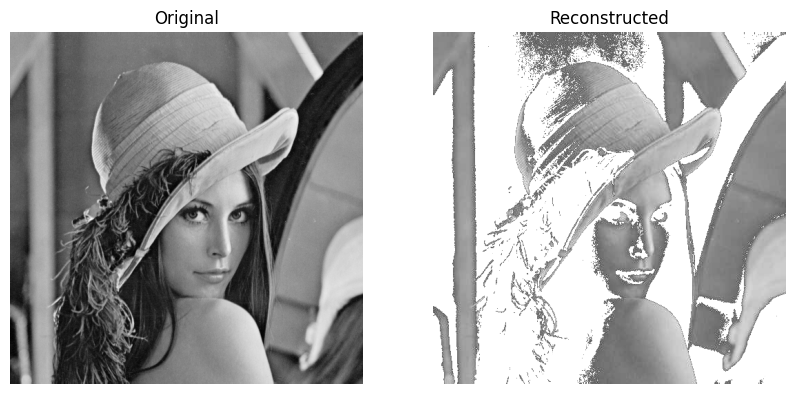

Reconstructed image saved.


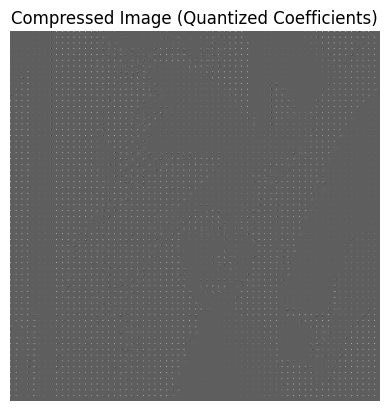

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import pickle

# Step 1: Defining DCT and IDCT functions
def dct_2d(block):
    """DCT is applied to JPEG images to convert spatial data into frequency data, concentrating most of the image's energy into a few low-frequency components. This facilitates efficient compression by discarding less perceptually important high-frequency data.

"""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct_2d(block):
    """Inverse DCT is performed on the JPEG image to transform the frequency-domain data back into the spatial domain. This reconstructs the image from its compressed representation for viewing or further processing.."""
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Step 2: Defining the quantization matrix and functions
   """ Quantization reduces the precision of high-frequency components using a quantization matrix, effectively compressing the data. This helps discard less noticeable details, reducing the file size while retaining essential image quality.."""
QUANTIZATION_MATRIX = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

def quantize(block, quant_matrix=QUANTIZATION_MATRIX):
    """Quantizing a block using the quantization matrix."""
    return np.round(block / quant_matrix)

def dequantize(block, quant_matrix=QUANTIZATION_MATRIX):
    """Dequantizing a block using the quantization matrix."""
    return block * quant_matrix

# Step 3: Defining block processing functions
def divide_into_blocks(image, block_size=8):
    """Dividing image into non-overlapping blocks of size block_size x block_size."""
    h, w = image.shape
    return image.reshape(h // block_size, block_size, -1, block_size).swapaxes(1, 2)

def combine_blocks(blocks, block_size=8):
    """Combining non-overlapping blocks into the full image."""
    h_blocks, w_blocks, _, _ = blocks.shape
    return blocks.swapaxes(1, 2).reshape(h_blocks * block_size, w_blocks * block_size)

# Step 4: Zigzag scanning
def zigzag_scan(block):
    """Zigzag scaning rearranges the values of a block into a single line starting with the most important low-frequency values."""
    indices = [(x, y) for x in range(8) for y in range(8)]
    indices.sort(key=lambda t: t[0] + t[1] if (t[0] + t[1]) % 2 == 0 else -t[1])
    return np.array([block[x, y] for x, y in indices])

def inverse_zigzag_scan(vector):
    """Reconstructing an 8x8 block from a zigzag-scanned vector."""
    if len(vector) != 64:
        raise ValueError(f"Expected a vector of length 64, got {len(vector)}")
    indices = [(x, y) for x in range(8) for y in range(8)]
    indices.sort(key=lambda t: t[0] + t[1] if (t[0] + t[1]) % 2 == 0 else -t[1])
    block = np.zeros((8, 8))
    for idx, (x, y) in enumerate(indices):
        block[x, y] = vector[idx]
    return block

# Step 5: Huffman coding
""" Huffman coding is used for lossless compression of quantized DCT coefficients. It reduces the size of the image without losing any information"""
""" It is used to reconstruct the original quantized DCT coefficients for image reconstruction."""
class Node:
    """Node class for Huffman tree."""
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

def build_huffman_tree(frequencies):
    """Build the Huffman tree."""
    nodes = [Node(sym, freq) for sym, freq in frequencies.items()]
    while len(nodes) > 1:
        nodes.sort(key=lambda x: x.freq)
        left = nodes.pop(0)
        right = nodes.pop(0)
        merged = Node(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        nodes.append(merged)
    return nodes[0]

def build_huffman_codes(tree, prefix="", codebook=None):
    """Generating Huffman codes from the tree."""
    if codebook is None:
        codebook = {}
    if tree.symbol is not None:
        codebook[tree.symbol] = prefix
    else:
        build_huffman_codes(tree.left, prefix + "0", codebook)
        build_huffman_codes(tree.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    """Encoding data using Huffman coding."""
    frequencies = {symbol: data.count(symbol) for symbol in set(data)}
    tree = build_huffman_tree(frequencies)
    codes = build_huffman_codes(tree)
    encoded_data = "".join(codes[symbol] for symbol in data)
    return encoded_data, tree

def huffman_decode(encoded_data, tree):
    """Decoding Huffman-encoded data."""
    decoded_data = []
    node = tree
    for bit in encoded_data:
        node = node.left if bit == "0" else node.right
        if node.symbol is not None:
            decoded_data.append(node.symbol)
            node = tree
    return decoded_data

# Step 6: Encode and decode functions
def encode_image(image):
    """Encoding the image using JPEG compression."""
    blocks = divide_into_blocks(image - 128)
    dct_blocks = [[dct_2d(block) for block in row] for row in blocks]
    quantized_blocks = [[quantize(block) for block in row] for row in dct_blocks]
    zigzag_blocks = [zigzag_scan(block) for row in quantized_blocks for block in row]
    flattened = [int(val) for block in zigzag_blocks for val in block]
    encoded_data, huffman_tree = huffman_encode(flattened)
    return encoded_data, huffman_tree, image.shape

def decode_image(encoded_data, huffman_tree, shape):
    """Decoding the image using JPEG decompression."""
    decoded_coefficients = huffman_decode(encoded_data, huffman_tree)
    num_blocks = (shape[0] // 8) * (shape[1] // 8)
    if len(decoded_coefficients) != num_blocks * 64:
        raise ValueError(f"Expected {num_blocks * 64} coefficients, got {len(decoded_coefficients)}")
    blocks = [inverse_zigzag_scan(decoded_coefficients[i:i + 64]) for i in range(0, len(decoded_coefficients), 64)]
    h_blocks = shape[0] // 8
    w_blocks = shape[1] // 8
    blocks = np.array(blocks).reshape(h_blocks, w_blocks, 8, 8)
    dequantized_blocks = [[dequantize(block) for block in row] for row in blocks]
    idct_blocks = [[idct_2d(block) for block in row] for row in dequantized_blocks]
    return np.clip(combine_blocks(np.array(idct_blocks)) + 128, 0, 255).astype(np.uint8)

# Step 7: Save/load to binary
def save_to_binary(filename, encoded_data, huffman_tree, shape):
    """Saving encoded data and Huffman tree to a binary file."""
    with open(filename, "wb") as f:
        pickle.dump((encoded_data, huffman_tree, shape), f)

def load_from_binary(filename):
    """Loading encoded data and Huffman tree from a binary file."""
    with open(filename, "rb") as f:
        return pickle.load(f)

# Step 8: Utility functions
def load_image(filepath):
    """Loading an image from a file and convert to grayscale."""
    image = Image.open(filepath).convert('L')
    return np.array(image)

def save_image(filepath, image):
    """Saving an image to a file."""
    Image.fromarray(image).save(filepath)

def psnr(original, reconstructed):
    """PSNR (Peak Signal-to-Noise Ratio) is used on a compressed image to measure the quality of reconstruction by comparing it to the original image."""
    """ It quantifies how much distortion or loss occurred during compression, with higher PSNR indicating better quality."""
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def display_images(original, reconstructed):
    """Displaying original and reconstructed images."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
    plt.show()

def visualize_compressed_image(encoded_data, huffman_tree, shape):
  """The visualize compressed image function decodes the Huffman-encoded image data, reconstructs the quantized DCT coefficients, and then reassembles the blocks into a full image.Visualizing the compressed image by reconstructing from quantized blocks"""

    decoded_coefficients = huffman_decode(encoded_data, huffman_tree)
    num_blocks = (shape[0] // 8) * (shape[1] // 8)
    if len(decoded_coefficients) != num_blocks * 64:
        raise ValueError(f"Expected {num_blocks * 64} coefficients, got {len(decoded_coefficients)}")
    blocks = [inverse_zigzag_scan(decoded_coefficients[i:i + 64]) for i in range(0, len(decoded_coefficients), 64)]
    h_blocks = shape[0] // 8
    w_blocks = shape[1] // 8
    blocks = np.array(blocks).reshape(h_blocks, w_blocks, 8, 8)
    quantized_image = combine_blocks(blocks)

    # Normalize the quantized image for display
    normalized_image = (quantized_image - quantized_image.min()) / (quantized_image.max() - quantized_image.min()) * 255
    normalized_image = normalized_image.astype(np.uint8)

    plt.imshow(normalized_image, cmap='gray')
    plt.title("Compressed Image (Quantized Coefficients)")
    plt.axis('off')
    plt.show()




# Testing the codec
image_path = "/content/Lenna_(test_image).png"
image = load_image(image_path)

# Encoding the image
encoded_data, huffman_tree, shape = encode_image(image)

# Saving encoded data
""" Saving the image in a binary file """
save_to_binary("compressed.bin", encoded_data, huffman_tree, shape)

# Load and decode
encoded_data, huffman_tree, shape = load_from_binary("compressed.bin")
reconstructed_image = decode_image(encoded_data, huffman_tree, shape)

# Evaluating the quality
""" Higher PSNR value indicates good quality image """
quality = psnr(image, reconstructed_image)
print(f"PSNR: {quality:.2f} dB")

# Displaying images
display_images(image, reconstructed_image)

# Saving the reconstructed image
save_image("reconstructed_image.jpg", reconstructed_image)
print("Reconstructed image saved.")
# Visualizing the compressed image
visualize_compressed_image(encoded_data, huffman_tree, shape)
